In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__)); Pkg.instantiate();
using BilinearControl
using BilinearControl.Problems
using BilinearControl.EDMD
import RobotDynamics as RD
using LinearAlgebra
using RobotZoo
using JLD2
using SparseArrays
using Plots
using Distributions
using Distributions: Normal
using Random
using FiniteDiff, ForwardDiff
using Test
using IterativeSolvers
using Preconditioners

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [3]:
Threads.nthreads()

8

In [4]:
include("learned_models/edmd_utils.jl");

In [5]:
## Visualizer
model = Problems.RexQuadrotor()
include(joinpath(Problems.VISDIR, "visualization.jl"))
vis = Visualizer()
delete!(vis)
set_quadrotor!(vis, model)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [6]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

# Define Planar Quadrotor Model

In [7]:
model = Problems.RexQuadrotor()
dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
tf = 2.0
dt = 0.02

T_ref = range(0,tf,step=dt);

In [8]:
n, m = RD.dims(model)
n

12

# Generate Data

In [9]:
Random.seed!(1)

# number of trajectories
num_train = 30
num_test = 10

# Generate a stabilizing LQR controller
Qlqr = Diagonal([10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
                1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Rlqr = Diagonal([1e-4, 1e-4, 1e-4, 1e-4])
xe = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ue = [0.25*9.81, 0.25*9.81, 0.25*9.81, 0.25*9.81]
ctrl_lqr = LQRController(dmodel, Qlqr, Rlqr, xe, ue, dt)

# Sample a bunch of initial conditions for the LQR controller
x0_sampler = Product([
    Uniform(-1.0,1.0),
    Uniform(-1.0,1.0),
    Uniform(-1.0,1.0),
    Uniform(-deg2rad(45),deg2rad(45)),
    Uniform(-deg2rad(45),deg2rad(45)),
    Uniform(-deg2rad(45),deg2rad(45)),
    Uniform(-0.5,0.5),
    Uniform(-0.5,0.5),
    Uniform(-0.5,0.5),
    Uniform(-0.25,0.25),
    Uniform(-0.25,0.25),
    Uniform(-0.25,0.25)
])
initial_conditions_lqr = [rand(x0_sampler) for _ in 1:num_train]
initial_conditions_test = [rand(x0_sampler) for _ in 1:num_test]

# Create data set
X_train, U_train = create_data(dmodel, ctrl_lqr, initial_conditions_lqr, tf, dt)
X_test, U_test = create_data(dmodel, ctrl_lqr, initial_conditions_test, tf, dt);

In [10]:
#save data
jldsave(joinpath(Problems.DATADIR, "rex_quadrotor_lqr_trajectories.jld2"); 
    X_train, U_train, X_test, U_test, tf, dt)

# Import Training/Test Data

In [11]:
lqr_traj = load(joinpath(Problems.DATADIR, "rex_quadrotor_lqr_trajectories.jld2"))

X_train = lqr_traj["X_train"]
U_train = lqr_traj["U_train"]
X_test = lqr_traj["X_test"]
U_test = lqr_traj["U_test"]
tf = lqr_traj["tf"]
dt = lqr_traj["dt"]

T_ref = range(0,tf,step=dt);

# Fit the Data using Nominal eDMD
This uses the standard eDMD model method used in the CalTech paper, which learns a model of the form:

$$ x^+ = A x + \sum_{i=1}^m u_i C_i x $$

In [12]:
# Define the basis functions
eigfuns = ["state", "sine", "cosine", "chebyshev"]
eigorders = [0,0,0,4];

In [13]:
# Fit the data
Z_train, Zu_train, kf = build_eigenfunctions(X_train, U_train, eigfuns, eigorders)

# A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
#     ["ridge", "lasso"]; 
#     edmd_weights=[10.1], 
#     mapping_weights=[0.0], 
#     algorithm=:qr
# );

A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
    ["na", "na"]; 
    edmd_weights=[0.0], 
    mapping_weights=[0.0], 
    algorithm=:qr
);

(T, K) = (219000, 26937)
issparse(X) = true
lambda = 0.0
(T, K) = (36000, 876)
issparse(X) = true
lambda = 0.0


In [14]:
# Save model
jldsave(joinpath(Problems.DATADIR,"rex_quadrotor_lqr_nominal_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import Nominal EDMD Model

In [15]:
cartpole_data = load(joinpath(Problems.DATADIR, "rex_quadrotor_lqr_nominal_eDMD_data.jld2"))
A_nom = cartpole_data["A"]
B_nom = cartpole_data["B"]
C_nom = cartpole_data["C"]
g_nom = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"];

# Evaluate the Nominal Fit
The fit is evaluated using:
$$ \frac{1}{P} \sum_{j=1}^P || g (A \varphi(x_j) + \sum_{i=1}^m u_{j,i} C_i \varphi(x_j)) - x_j^+ || $$

where $y = \varphi(x)$ is the Koopman transform.

In [16]:
err_train = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_train, U_train)
err_test = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)

Train Error: 0.004253481975039062
Test Error:  0.5187454508031494


### Define the Bilinear Model

In [17]:
model_bilinear = EDMDModel(A_nom,B_nom,C_nom,g_nom,kf,dt,"planar_quadrotor")
n,m = RD.dims(model_bilinear)
n0 = originalstatedim(model_bilinear)
println("New state dimension: ", n)

New state dimension: 73


### Compare Linearization
To see if the learned model captures the dynamics, we'll evaluate the effective `A` and `B` dynamics Jaocbians of the learned model on the original dynamics, and compare to the nominal Jacobians.

In [18]:
# Define the equilibrium
xe = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ue = [0.25*9.81, 0.25*9.81, 0.25*9.81, 0.25*9.81]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)
ye = expandstate(model_bilinear, xe);

In [19]:
# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_og = J[:,1:n0]
B_og = J[:,n0+1:end];

In [20]:
# Bilinear Jacobians
function dynamics_bilinear(x,u,t,dt)
    y = expandstate(model_bilinear, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear, yn, y, u, t, dt)
    originalstate(model_bilinear, yn)
end

A_bil_nom = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear(x,ue,0.0,dt), xe)
B_bil_nom = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear(xe,u,0.0,dt), ue);

In [21]:
A_og

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.007848  0.0  …  0.0    0.0       1.308e-5  0.0
 0.0  1.0  0.0  -0.007848  0.0       0.0     0.0   -1.308e-5  0.0       0.0
 0.0  0.0  1.0   0.0       0.0       0.0     0.02   0.0       0.0       0.0
 0.0  0.0  0.0   1.0       0.0       0.0     0.0    0.005     0.0       0.0
 0.0  0.0  0.0   0.0       1.0       0.0     0.0    0.0       0.005     0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …  0.0    0.0       0.0       0.005
 0.0  0.0  0.0   0.0       0.7848    0.0     0.0    0.0       0.001962  0.0
 0.0  0.0  0.0  -0.7848    0.0       0.0     0.0   -0.001962  0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     1.0    0.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    1.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …  0.0    0.0       1.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    0.0       0.0       1.0

In [22]:
A_bil_nom

12×12 Matrix{Float64}:
   -3.02954    -3.83441      8.24526  …    1.46039     -1.53453      3.31594
   -1.19064     0.497666    -1.38157       0.190858    -0.453463    -1.10408
   -1.0112     -1.57492      2.55736       0.599977    -0.385081     1.02594
  -42.6373    -18.2156      81.6228        6.94087    -16.237       15.0008
  121.222     129.084     -242.818       -49.1697      46.1722    -104.048
  100.17       69.4372    -190.85     …  -26.4492      38.1487     -55.2886
 -420.228    -395.955      860.603       150.806     -160.031      342.654
 -127.798     -58.6551    -119.731        22.2934     -48.6726    -103.012
  -99.0      -157.365      152.563        59.9483     -37.7004     102.717
   68.386      40.114      -92.172       -14.2748      26.041      -14.1034
 -169.441    -159.547      298.973    …   60.774      -63.5327     115.474
  -13.6688     -7.64224     22.6985        2.9104      -5.20591      5.8164

In [23]:
B_og

12×4 Matrix{Float64}:
 -2.02384e-8   -2.02302e-8    2.02384e-8    2.02302e-8
 -2.01866e-8    2.01783e-8    2.01866e-8   -2.01783e-8
  2.44101e-6    2.44101e-6    2.44101e-6    2.44101e-6
  1.54332e-5   -1.54269e-5   -1.54332e-5    1.54269e-5
 -1.54728e-5   -1.54665e-5    1.54728e-5    1.54665e-5
  6.72649e-7   -6.72649e-7    6.72649e-7   -6.72649e-7
 -4.04768e-6   -4.04603e-6    4.04768e-6    4.04603e-6
 -4.03731e-6    4.03567e-6    4.03731e-6   -4.03567e-6
  0.000244101   0.000244101   0.000244101   0.000244101
  0.00617326   -0.00617075   -0.00617326    0.00617075
 -0.00618911   -0.00618659    0.00618911    0.00618659
  0.00026906   -0.00026906    0.00026906   -0.00026906

In [24]:
B_bil_nom

12×4 Matrix{Float64}:
  0.051059     0.000731383   0.00332605  -0.000501947
 -0.00165333   0.00431774   -0.0119328    0.000118994
  0.014622    -0.00331482   -0.00107773   9.64255e-5
  0.38122      0.148144      0.0117173   -0.000403506
 -1.58692      0.0461765    -0.0673352   -0.00036018
 -1.05678     -0.183906     -0.0269766    0.00345526
  5.30124      0.102229      0.347097    -0.0501429
 -0.0525304    0.433061     -1.18463      0.0112165
  1.45061     -0.343295     -0.105675     0.0099199
 -0.53329     -0.18737       0.112904    -0.00290013
  1.95921      0.0480239    -0.0257424   -0.00115507
  0.12225      0.0359801    -0.00715026  -0.000719064

# Try Stabilizing Nominal Model using LQR

In [25]:
# Calculate LQR Gain 
Qlqr = Diagonal([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4])
Rlqr = Diagonal([1e-4, 1e-4, 1e-4, 1e-4])

K_og = dlqr(A_og, B_og, Qlqr, Rlqr)
K_bil_nom = dlqr(A_bil_nom, B_bil_nom, Qlqr, Rlqr);

In [26]:
# Evaluate stability
isstable_nominal = maximum(abs.(eigvals(A_og - B_og*K_og))) < 1.0
isstable_bilinear = maximum(abs.(eigvals(A_bil_nom - B_bil_nom*K_bil_nom))) < 1.0
isstable_nominal_with_bilinear = maximum(abs.(eigvals(A_og - B_og*K_bil_nom))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


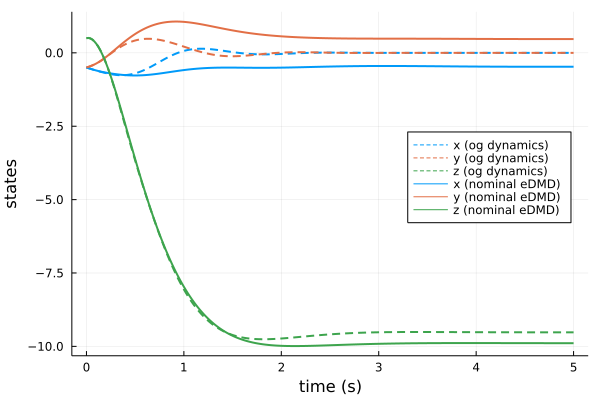

In [27]:
# Simulate nominal model with LQR gain from bilinear model

tf_sim = 5.0
Tsim_lqr_nominal = range(0,tf_sim,step=dt)

# x0 = [0,pi-deg2rad(1),0,0]
x0 = [-0.5, -0.5, 0.5, -deg2rad(20), deg2rad(50), -deg2rad(20), -1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

ctrl_lqr_og = LQRController(K_og, xe, ue)
ctrl_lqr_nominal = LQRController(K_bil_nom, xe, ue)

Xsim_lqr_og, = simulatewithcontroller(dmodel, ctrl_lqr_og, x0, tf_sim, dt)
Xsim_lqr_nominal, = simulatewithcontroller(dmodel, ctrl_lqr_nominal, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:3, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "y (og dynamics)" "z (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2 3])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:3, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "y (nominal eDMD)" "z (nominal eDMD)"], legend=:right, lw=2,
            color=[1 2 3])

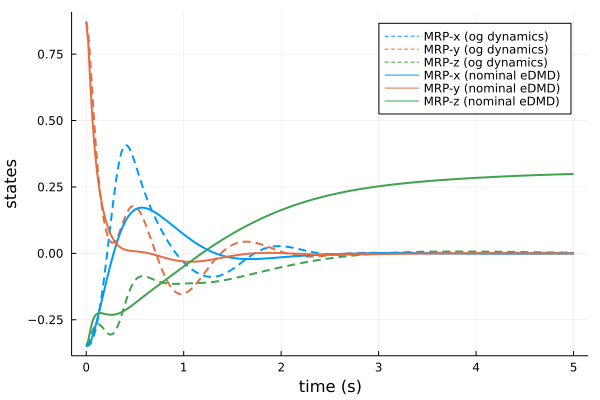

In [28]:
plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=4:6, xlabel="time (s)", ylabel="states",
            label=["MRP-x (og dynamics)" "MRP-y (og dynamics)" "MRP-z (og dynamics)"], legend=:topright, lw=2,
            linestyle=:dash, color=[1 2 3])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=4:6, xlabel="time (s)", ylabel="states",
            label=["MRP-x (nominal eDMD)" "MRP-y (nominal eDMD)" "MRP-z (nominal eDMD)"], legend=:topright, lw=2,
            color=[1 2 3])

# Evaluate New eDMD Model with Penalties on Jacobians
Here we incorporate derivative data by penalizing the difference of the Jacobian of the learned model from the expected Jacobians of the nominal model, e.g.:

$$ \sum_{j=1}^P || \frac{\partial}{\partial x} G \hat{f}(\varphi(x_j), u_j) - A_j ||^2 $$

where 

$$ \hat{f}(y,u) = A y + B u + \sum_{i=1}^m u_i C_i y $$

are the learned bilinear dynamics.

In [ ]:
# Generate Jacobians
xn = zeros(n0)
jacobians = map(CartesianIndices(U_train)) do cind
    k = cind[1]
    x = X_train[cind]
    u = U_train[cind]
    z = RD.KnotPoint{n0,m}(x,u,T_ref[k],dt)
    J = zeros(n0,n0+m)
    RD.jacobian!(
        RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, z 
    )
    J
end
A_train = map(J->J[:,1:n0], jacobians)
B_train = map(J->J[:,n0+1:end], jacobians)

# Convert states to lifted Koopman states
Y_train = map(kf, X_train)

# Calculate Jacobian of Koopman transform
F_train = map(@view X_train[1:end-1,:]) do x
    sparse(ForwardDiff.jacobian(x->expandstate(model_bilinear,x), x))
end;

### Build Least-squares problem
Find the eDMD data `A`, `B`, and `C` that minimize the following residual:

$$\sum_{j=1}^P (1-\alpha)|| A y_j + B u_j + \sum_{i=1}^m u_{j,i} C_i x_j - y_j^+ ||^2 + 
\alpha || G (A + \sum_{i=1}^m u_{j,i} C_j) F_j  - A_j ||^2 + 
\alpha || G (B + [C_1 x_j \dots C_m x_j]) - B_j ||^2  $$

where $F_j = \partial \varphi(x_j) / \partial x$.

This is equivalent to 

$$ (1-\alpha)|| E Z_{1:P} - Y_{1:P}^+ ||^2 + 
\alpha || G E \hat{A}_{1:P} - A_{1:P} ||^2 +
\alpha || G E \hat{B}_{1:P} - B_{1:P} ||^2 $$

where

$$ E = \begin{bmatrix} A & B & C_1 & \dots & C_m \end{bmatrix} \in \mathbb{R}^{n \times p} $$
$$ Z_j = \begin{bmatrix} 
    x_j \\ u_j \\ u_{j,1} x_j \\ \vdots \\ u_{j,m} x_j 
\end{bmatrix} \in \mathbb{R}^{p}, \quad
\hat{A}_j = \begin{bmatrix} 
    I_n \\ 0_{m,n} \\ u_{j,1} I_n \\ \vdots \\ u_{j,m} I_n 
\end{bmatrix} \in \mathbb{R}^{p \times n}, \quad
\hat{B}_j = \begin{bmatrix} 
    0_{n,m} \\ I_m \\ [x_j \; 0 \; \dots \; 0] \\ \vdots \\ [0 \; \dots \; 0 \; x_j] 
\end{bmatrix} \in \mathbb{R}^{p \times m}
$$

which is equivalent to 

$$ \left\lVert 
\begin{bmatrix} 
    Z_{1:P}^T \otimes I_n \\
    \hat{A}_{1:P}^T \otimes G \\
    \hat{B}_{1:P}^T \otimes G 
\end{bmatrix} \text{vec}(E) - 
\begin{bmatrix}
    \text{vec}{Y_{1:P}^+}\\
    \text{vec}{A_{1:P}^+}\\
    \text{vec}{B_{1:P}^+}\\
\end{bmatrix}
\right\rVert^2 $$

In [ ]:
# Create a sparse version of the G Jacobian
G = spdiagm(n0,n,1=>ones(n0)) 
#@test norm(G - model_bilinear.g) < 1e-8

# Build Least Squares Problem
W,s = BilinearControl.EDMD.build_edmd_data(
    Z_train, U_train, A_train, B_train, F_train, model_bilinear.g
);

In [ ]:
println(typeof(W))
println(typeof(s))

In [ ]:
println(size(W))
println(size(s))

In [ ]:
Wsparse = sparse(W)

### Solve the Least-squares Problem

In [ ]:
# @time Wsparse = sparse(W)
# @time F = qr(Wsparse)
# @time x = F \ s
# norm(W*x - s)

In [ ]:
@time x = IterativeSolvers.lsqr(Wsparse, s)

In [ ]:
# BilinearControl.matdensity(Wsparse)

In [ ]:
# Extract out bilinear dynamics
n = length(Z_train[1])
E = reshape(x,n,:)
A = E[:,1:n]
B = E[:,n .+ (1:m)]
C = E[:,n+m .+ (1:n*m)]

C_list = Matrix{Float64}[]
    
for i in 1:m
    C_i = C[:, (i-1)*n+1:i*n]
    push!(C_list, C_i)
end

return A, B, C_list, Matrix(g)

C = C_list;

In [ ]:
# Save data
jldsave(joinpath(Problems.DATADIR,"rex_quadrotor_lqr_jacobian_penalized_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import New Model

In [29]:
cartpole_data = load(joinpath(Problems.DATADIR, "rex_quadrotor_lqr_jacobian_penalized_eDMD_data.jld2"))
A_jacpen = cartpole_data["A"]
B_jacpen = cartpole_data["B"]
C_jacpen = cartpole_data["C"]
g_jacpen = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"]

T_ref = range(0,tf,step=dt);

# Evaluate the New Fit

In [30]:
# Evaluate the Fit
err_train2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_train, U_train)
err_test2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)
println("")
println("New Train Error: ", err_train2)
println("New Test Error:  ", err_test2)

Train Error: 0.004253481975039062
Test Error:  0.5187454508031494

New Train Error: 71.1016257475417
New Test Error:  192.58199419635972


In [31]:
model_bilinear_jacpen = EDMDModel(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, dt, "cartpole")
n,m = RD.dims(model_bilinear_jacpen)
n0 = originalstatedim(model_bilinear_jacpen);

In [32]:
# Get A,B for new system
function dynamics_bilinear_jacpen(x,u,t,dt)
    y = expandstate(model_bilinear_jacpen, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear_jacpen, yn, y, u, t, dt)
    originalstate(model_bilinear_jacpen, yn)
end

A_bil_jacpen = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear_jacpen(x,ue,0.0,dt), xe)
B_bil_jacpen = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear_jacpen(xe,u,0.0,dt), ue);

**Compare the Jacobians with Nominal model**

In [33]:
A_og

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.007848  0.0  …  0.0    0.0       1.308e-5  0.0
 0.0  1.0  0.0  -0.007848  0.0       0.0     0.0   -1.308e-5  0.0       0.0
 0.0  0.0  1.0   0.0       0.0       0.0     0.02   0.0       0.0       0.0
 0.0  0.0  0.0   1.0       0.0       0.0     0.0    0.005     0.0       0.0
 0.0  0.0  0.0   0.0       1.0       0.0     0.0    0.0       0.005     0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …  0.0    0.0       0.0       0.005
 0.0  0.0  0.0   0.0       0.7848    0.0     0.0    0.0       0.001962  0.0
 0.0  0.0  0.0  -0.7848    0.0       0.0     0.0   -0.001962  0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     1.0    0.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    1.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …  0.0    0.0       1.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    0.0       0.0       1.0

In [34]:
A_bil_jacpen

12×12 Matrix{Float64}:
  0.000527274  -4.39074e-6   3.69499e-7  …   3.85764e-5    8.60391e-6
 -1.81232e-6    0.00065834   4.96862e-6     -3.36321e-6   -1.43782e-5
 -5.43858e-6    4.20802e-6   4.58786e-5     -1.01355e-5    6.92596e-6
 -5.55297e-7    3.24635e-6   8.97851e-7     -9.383e-6     -2.60505e-7
 -2.65209e-6    8.8761e-7   -4.41195e-7      8.61977e-6   -1.15445e-6
  2.25191e-6    4.57262e-7  -1.15605e-6  …  -4.52151e-6   -1.7516e-5
 -3.58574e-5   -8.44873e-6  -3.01079e-7     -7.76388e-5    2.60057e-6
 -3.51877e-6   -4.36645e-5  -9.05e-6        -1.7819e-5     1.42566e-5
 -8.32317e-6    1.89505e-5   6.42758e-6     -5.31601e-5    7.9028e-6
  1.89258e-6   -5.38638e-5  -1.12949e-6      0.000162703   2.21487e-6
  4.9552e-5     1.81064e-6   5.31526e-6  …   0.000226319   9.86736e-6
 -6.21354e-6   -1.01747e-6   1.41488e-6     -7.00582e-6    0.000689951

In [35]:
B_og

12×4 Matrix{Float64}:
 -2.02384e-8   -2.02302e-8    2.02384e-8    2.02302e-8
 -2.01866e-8    2.01783e-8    2.01866e-8   -2.01783e-8
  2.44101e-6    2.44101e-6    2.44101e-6    2.44101e-6
  1.54332e-5   -1.54269e-5   -1.54332e-5    1.54269e-5
 -1.54728e-5   -1.54665e-5    1.54728e-5    1.54665e-5
  6.72649e-7   -6.72649e-7    6.72649e-7   -6.72649e-7
 -4.04768e-6   -4.04603e-6    4.04768e-6    4.04603e-6
 -4.03731e-6    4.03567e-6    4.03731e-6   -4.03567e-6
  0.000244101   0.000244101   0.000244101   0.000244101
  0.00617326   -0.00617075   -0.00617326    0.00617075
 -0.00618911   -0.00618659    0.00618911    0.00618659
  0.00026906   -0.00026906    0.00026906   -0.00026906

In [36]:
B_bil_jacpen

12×4 Matrix{Float64}:
 -2.04291e-5   -4.31366e-5   -1.25603e-5    1.19778e-5
 -4.38482e-5   -7.16747e-6   -2.79454e-5   -6.93757e-5
 -1.09286e-5    9.28835e-6   -8.06677e-6   -3.04673e-5
  9.02913e-6   -8.085e-7      5.31155e-6    1.55379e-5
 -5.0326e-6    -9.47635e-6   -3.76361e-6    2.28616e-6
 -8.16142e-6   -1.2595e-5    -6.73947e-6   -5.0655e-6
  0.00037335    0.000405403   0.000266318   0.000225239
  0.000126446  -5.83211e-5    5.43616e-5    0.000257825
  0.000204665   0.000119212   0.000146731   0.000238579
 -5.17573e-5   -9.17983e-5   -6.2951e-5    -1.41552e-5
 -7.23066e-5   -0.000115102  -4.09637e-5   -5.08754e-6
  2.03179e-5    2.74233e-5    1.69497e-5    9.88153e-6

# Try Stabilizing New Model using LQR

In [37]:
K_bil_jacpen = dlqr(A_bil_jacpen, B_bil_jacpen, Qlqr, Rlqr);

In [38]:
# Evaluate stability
isstable_bilinear2 = maximum(abs.(eigvals(A_bil_jacpen - B_bil_jacpen*K_bil_jacpen))) < 1.0
isstable_nominal_with_bilinear2 = maximum(abs.(eigvals(A_og - B_og*K_bil_jacpen))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear2)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear2)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  false


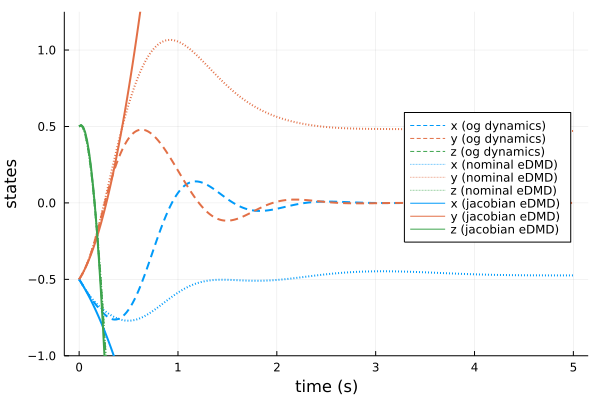

In [45]:
tf_sim = 5.0
Tsim_lqr_jacpen = range(0,tf_sim,step=dt)

x0 = [-0.5, -0.5, 0.5, -deg2rad(20), deg2rad(50), -deg2rad(20), -1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

ctrl_lqr_jacpen = LQRController(K_bil_jacpen, xe, ue)
Xsim_lqr_jacpen, = simulatewithcontroller(dmodel, ctrl_lqr_jacpen, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:3, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "y (og dynamics)" "z (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2 3])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:3, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "y (nominal eDMD)" "z (nominal eDMD)"], legend=:right, lw=2,
            linestyle=:dot, color=[1 2 3])
plotstates!(Tsim_lqr_jacpen, Xsim_lqr_jacpen, inds=1:3, xlabel="time (s)", ylabel="states",
            label=["x (jacobian eDMD)" "y (jacobian eDMD)" "z (jacobian eDMD)"], legend=:right, lw=2,
            color=[1 2 3])
ylims!((-1,1.25))

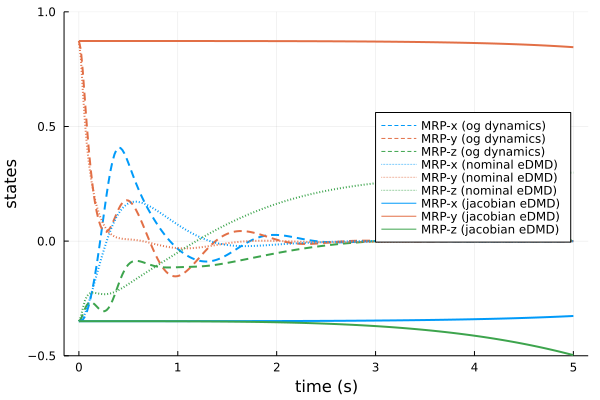

In [46]:
plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=4:6, xlabel="time (s)", ylabel="states",
            label=["MRP-x (og dynamics)" "MRP-y (og dynamics)" "MRP-z (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2 3])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=4:6, xlabel="time (s)", ylabel="states",
            label=["MRP-x (nominal eDMD)" "MRP-y (nominal eDMD)" "MRP-z (nominal eDMD)"], legend=:right, lw=2,
            linestyle=:dot, color=[1 2 3])
plotstates!(Tsim_lqr_jacpen, Xsim_lqr_jacpen, inds=4:6, xlabel="time (s)", ylabel="states",
            label=["MRP-x (jacobian eDMD)" "MRP-y (jacobian eDMD)" "MRP-z (jacobian eDMD)"], legend=:right, lw=2,
            color=[1 2 3])
ylims!((-0.5,1))

In [ ]:
render(vis)

In [ ]:
# visualize!(vis, model, tf_sim, Xsim_lqr_nominal)
visualize!(vis, model, tf_sim, Xsim_lqr_jacpen)